C:\Users\Emre Eser\Desktop\jup
[INFO] loading images...
[INFO] compiling model...
[INFO] training head...
Epoch 1/80
287/287 [==============================] - 80s 267ms/step - loss: 0.4619 - accuracy: 0.6890 - val_loss: 0.1799 - val_accuracy: 0.9253
Epoch 2/80
287/287 [==============================] - 76s 266ms/step - loss: 0.1961 - accuracy: 0.9220 - val_loss: 0.1256 - val_accuracy: 0.9497
Epoch 3/80
287/287 [==============================] - 76s 263ms/step - loss: 0.1601 - accuracy: 0.9268 - val_loss: 0.0976 - val_accuracy: 0.9566
Epoch 4/80
287/287 [==============================] - 75s 261ms/step - loss: 0.1317 - accuracy: 0.9395 - val_loss: 0.0862 - val_accuracy: 0.9618
Epoch 5/80
287/287 [==============================] - 76s 264ms/step - loss: 0.1183 - accuracy: 0.9448 - val_loss: 0.0709 - val_accuracy: 0.9740
Epoch 6/80
287/287 [==============================] - 75s 261ms/step - loss: 0.1026 - accuracy: 0.9535 - val_loss: 0.0628 - val_accuracy: 0.9826
Epoch 7/80
287/287 [====

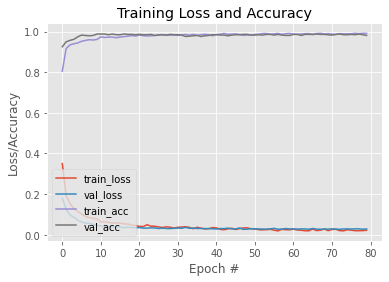

In [9]:
# necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

print(os.getcwd())

dataset_path=os.getcwd()+"//dataset"
model_path=os.getcwd()+"//model"
plot_path=os.getcwd()+"//plot"


# learning rate, number of epochs ,
# and batch size
INIT_LR = 1e-4
EPOCHS = 80
BS = 8

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
imagePaths = [imagePath.replace("\\","//",-1) for imagePath in imagePaths]
data = []
labels = []

for imagePath in imagePaths:
    # maske var yok diye label
    label = imagePath.split("//")[-2]

    # resimleri ayarla
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # resimlere ve etiketleri diziye at
    data.append(image)
    labels.append(label)

# image and labels to numpy array..

data = np.array(data, dtype="float32")
labels = np.array(labels)
LB = LabelBinarizer()
labels = LB.fit_transform(labels)


# %80 train %20 test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,stratify=labels, random_state=42)

# data growing
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# create head model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# it will be real model
model = Model(inputs=baseModel.input, outputs=headModel)

## layer looping and freeze
# * it doesn't update for first training *
for layer in baseModel.layers:
	layer.trainable = False

# compile ediyoruz
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

#predicting on the test
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# finding index for each image on the test
# big probability label label
predIdxs = np.argmax(predIdxs, axis=1)

#save model
print("[INFO] saving mask detector model... path: %s"%(model_path+".h5"))
model.save(model_path+".h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)